In [1]:
# import modules
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

# import from sklearn
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score



### I'm going to run K-Means clustering on the predicted dataframe to see what set's pathogenic and non-pathogenic variants apart

### I also want to try SVM and logistic regression with polynomial features

In [18]:
#importing the data
predDF=pd.read_csv('/Users/leekapp/Desktop/CS254/Assignments/FinalProject/annotatedRndPredDF1.csv')
predDF.head(5)

,Unnamed: 0,base,gene,annotation,counts_hom,counts_het,mutation,prediction
0,0,577,MT-TF,tRNA,0,2,transition,2.0
1,1,580,MT-TF,tRNA,0,1,transition,2.0
2,2,585,MT-TF,tRNA,0,2,transition,2.0
3,3,588,MT-TF,tRNA,0,2,transition,2.0
4,4,591,MT-TF,tRNA,1,0,transversion,2.0


In [19]:
X = predDF.iloc[:, 0:6]
X.head(5)

,Unnamed: 0,base,gene,annotation,counts_hom,counts_het
0,0,577,MT-TF,tRNA,0,2
1,1,580,MT-TF,tRNA,0,1
2,2,585,MT-TF,tRNA,0,2
3,3,588,MT-TF,tRNA,0,2
4,4,591,MT-TF,tRNA,1,0


In [20]:
predDF.prediction.value_counts() #looks like 'no' is predicted a lot more than 'yes'

1.0    10536
2.0     2163
Name: prediction, dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


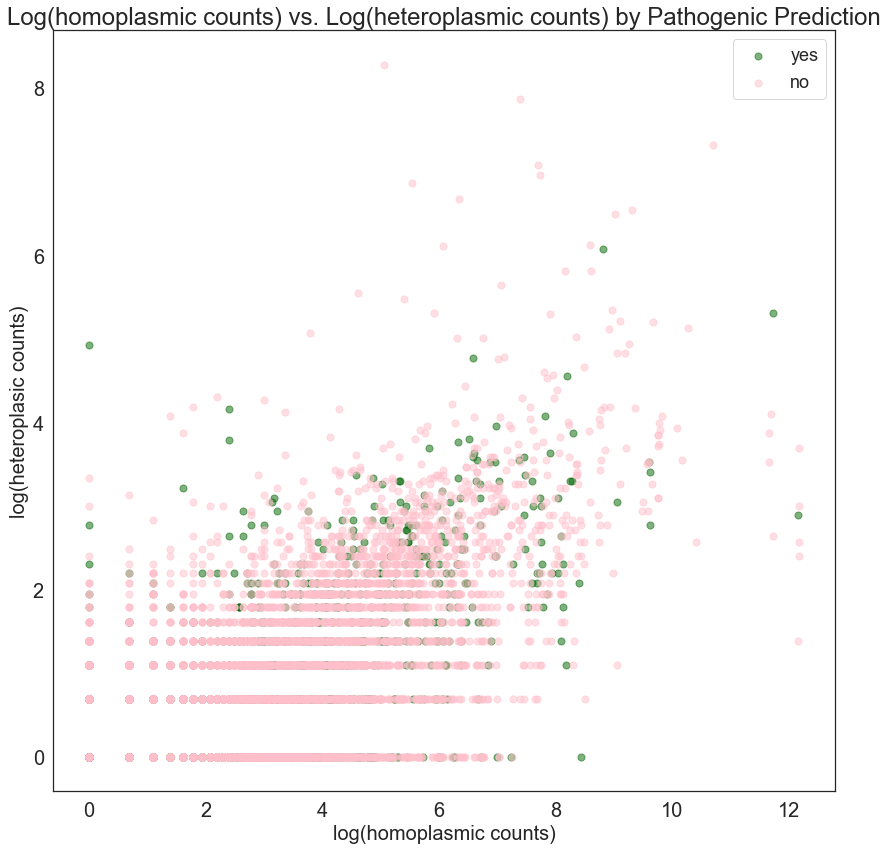

In [21]:
plt.figure(figsize=(14, 14))
yes_points = predDF[predDF['prediction']==2]
no_points = predDF[predDF['prediction']==1]
plt.scatter(np.log(yes_points.iloc[:, 4]), np.log(yes_points.iloc[:, 5]), c='darkgreen', s=50,alpha=.5,label='yes')
plt.scatter(np.log(no_points.iloc[:, 4]), np.log(no_points.iloc[:, 5]), c='pink', s=50,alpha=.5,label='no')
plt.title("Log(homoplasmic counts) vs. Log(heteroplasmic counts) by Pathogenic Prediction",fontsize=24);
plt.xlabel('log(homoplasmic counts)', fontsize=20)
plt.ylabel('log(heteroplasic counts)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=18);
plt.savefig('logPredPlot.pdf')

### Importing numeric version of data

In [24]:
numPredDF = pd.read_csv('/Users/leekapp/Desktop/CS254/Assignments/FinalProject/rndPredDF1.csv')

In [37]:
numPredDF['counts_hom'][numPredDF['counts_hom']==0]=0.0001
numPredDF['counts_het'][numPredDF['counts_het']==0]=0.0001
numPredDF.head(5)

<ipython-input-37-5deb87d827ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numPredDF['counts_het'][numPredDF['counts_het']==0]=0.0001


,Unnamed: 0,base,gene,annotation,counts_hom,counts_het,mutation,prediction
0,0,577,MT-TF,8,0.0001,2.0000,2,2.0
1,1,580,MT-TF,8,0.0001,1.0000,2,2.0
2,2,585,MT-TF,8,0.0001,2.0000,2,2.0
3,3,588,MT-TF,8,0.0001,2.0000,2,2.0
4,4,591,MT-TF,8,1.0000,0.0001,3,2.0


In [38]:
X = numPredDF.iloc[:, 3:6]
X.head(5)

,annotation,counts_hom,counts_het
0,8,0.0001,2.0000
1,8,0.0001,1.0000
2,8,0.0001,2.0000
3,8,0.0001,2.0000
4,8,1.0000,0.0001


In [39]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [40]:
preds = pd.Series(y_kmeans)
preds[preds==1].size

12

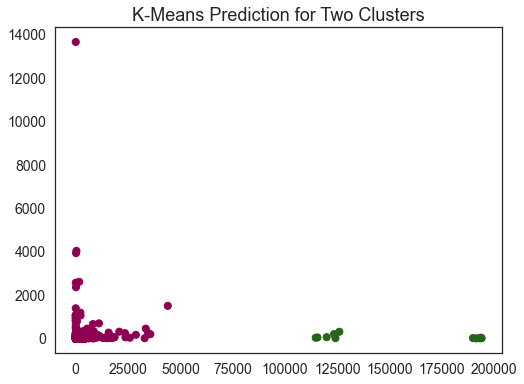

In [41]:
plt.figure(figsize=(8, 6))
plt.scatter(X.iloc[:, 1], X.iloc[:, 2], c=y_kmeans, s=50, cmap='PiYG')
plt.title("K-Means Prediction for Two Clusters", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('kmeansPredPlot.pdf')

### Gaussian RBF SVM classifier (default kernel)

In [80]:
numericDF = pd.read_csv('/Users/leekapp/Desktop/CS254/Assignments/FinalProject/numPathKnown.csv')
treeDF = numericDF.drop(columns = ['log_hom', 'log_het'])
treeDF.head(5)

,base,gene,annotation,counts_hom,counts_het,pathogenic,mutation
0,593,MT-TF,8,480.0,41.000,2,2
1,593,MT-TF,8,86.0,0.001,2,1
2,593,MT-TF,8,9.0,0.001,2,3
3,593,MT-TF,8,37.0,3.000,2,3
4,606,MT-TF,8,1.0,0.001,2,3


In [81]:
treeDF.pathogenic.value_counts()

2    852
1     82
Name: pathogenic, dtype: int64

In [82]:
### making a new DF where 'pathogenic' == 'yes'
yesDF = treeDF[treeDF['pathogenic']==2]
print('Yes: ', yesDF.pathogenic.value_counts())

###extracting the rows where 'pathogenic' == 'no'
noDF = treeDF[treeDF['pathogenic']==1]
print('No: ', noDF.pathogenic.value_counts())

Yes:  2    852
Name: pathogenic, dtype: int64
No:  1    82
Name: pathogenic, dtype: int64


In [83]:
### sampling 82rows for 'pathogenic' == 'yes'
yesSample = yesDF.sample(n=82, random_state=13)
yesSample.head(10)

,base,gene,annotation,counts_hom,counts_het,pathogenic,mutation
561,9966,MT-CO3,1,1092.000,29.000,2,2
273,4659,MT-ND2,1,0.001,1.000,2,3
607,12015,MT-ND4,2,6.000,4.000,2,2
348,6307,MT-CO1,2,1.000,0.001,2,3
756,15451,MT-CYB,3,12.000,3.000,2,2
321,5780,MT-TC,8,162.000,0.001,2,2
831,185,MT-CRb,5,21.000,0.001,2,1
729,14831,MT-CYB,1,571.000,41.000,2,2
109,2158,MT-RNR2,7,1871.000,9.000,2,2
21,745,MT-RNR1,7,0.001,1.000,2,1


In [84]:
balancedDF = pd.concat([yesSample, noDF])
balancedDF.pathogenic.value_counts()

2    82
1    82
Name: pathogenic, dtype: int64

In [85]:
X_train, X_test, y_train, y_test = train_test_split(balancedDF.drop(['base', 'gene', 'pathogenic'], axis = 1), balancedDF.loc[:, 'pathogenic'], test_size=0.25, random_state=13)

In [69]:
helix_svc = SVC()
helix_svc.fit(X_train, y_train)
svm_pred = helix_svc.predict(X_test)

[[ 2 17]
 [ 0 22]]
0.59


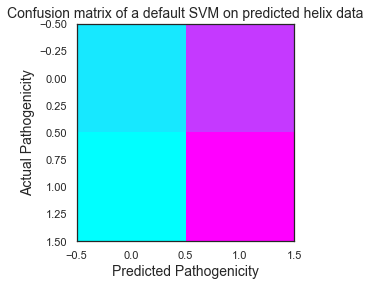

In [71]:
conf_mat = confusion_matrix(y_test, svm_pred)
print(conf_mat)

confusion = pd.DataFrame(conf_mat, index = ['no', 'yes'],
                         columns = ['no', 'yes'])

plt.figure()
plt.imshow(confusion, cmap = "cool")
plt.xlabel('Predicted Pathogenicity', fontsize=14)
plt.ylabel('Actual Pathogenicity', fontsize=14)
plt.title("Confusion matrix of a default SVM on predicted helix data", fontsize=14);
score="{:.2f}".format(helix_polysvc.score(X_test,y_test)) #this is the test score!? Must be overfitting
print(score)

In [72]:
print(classification_report(y_test, svm_pred, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       1.00      0.11      0.19        19
         yes       0.56      1.00      0.72        22

    accuracy                           0.59        41
   macro avg       0.78      0.55      0.46        41
weighted avg       0.77      0.59      0.48        41



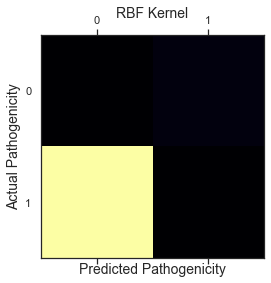

In [151]:
# The visualize_confusion takes a confusion matrix (2D numpy array) and returns a heatmap of normalized error rates
# for each class
def visualize_confusion(conf_matrix, title):
    row_sums = conf_matrix.sum(axis=1)
    normalized = conf_matrix/row_sums
    np.fill_diagonal(normalized, 0)
    plt.matshow(normalized, cmap = "inferno")
    plt.xlabel('Predicted Pathogenicity', fontsize=14)
    plt.ylabel('Actual Pathogenicity', fontsize=14)
    plt.title(title,fontsize=14)
    plt.show()
visualize_confusion(conf_mat, title="RBF Kernel")

### SVM with polynomial kernel

In [73]:
helix_polysvc = SVC(kernel='poly')
helix_polysvc.fit(X_train, y_train)
svm_polypred = helix_polysvc.predict(X_test)

[[ 2 17]
 [ 0 22]]
0.59


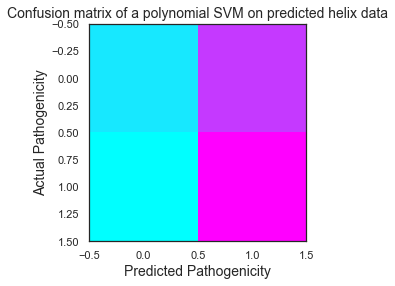

In [74]:
conf_mat = confusion_matrix(y_test, svm_polypred)
print(conf_mat)

confusion = pd.DataFrame(conf_mat, index = ['no', 'yes'],
                         columns = ['no', 'yes'])

plt.figure()
plt.imshow(confusion, cmap = "cool")
plt.xlabel('Predicted Pathogenicity', fontsize=14)
plt.ylabel('Actual Pathogenicity', fontsize=14)
plt.title("Confusion matrix of a polynomial SVM on predicted helix data", fontsize=14);
score="{:.2f}".format(helix_polysvc.score(X_test,y_test)) #this is the test score!? Must be overfitting
print(score)

In [75]:
print(classification_report(y_test, svm_polypred, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       1.00      0.11      0.19        19
         yes       0.56      1.00      0.72        22

    accuracy                           0.59        41
   macro avg       0.78      0.55      0.46        41
weighted avg       0.77      0.59      0.48        41



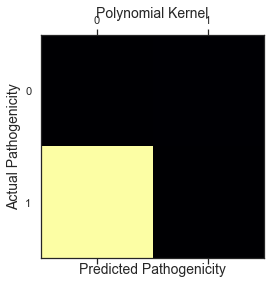

In [155]:
visualize_confusion(conf_mat, title="Polynomial Kernel")

### SVM with sigmoid kernel

In [88]:
helix_sigsvc = SVC(kernel='sigmoid')
helix_sigsvc.fit(X_train, y_train)
svm_sigpred = helix_sigsvc.predict(X_test)

[[ 2 17]
 [ 0 22]]
0.59


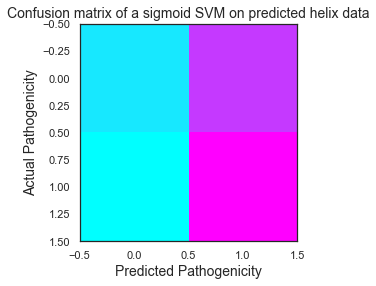

In [89]:
conf_mat = confusion_matrix(y_test, svm_sigpred)
print(conf_mat)

confusion = pd.DataFrame(conf_mat, index = ['no', 'yes'],
                         columns = ['no', 'yes'])

plt.figure()
plt.imshow(confusion, cmap = "cool")
plt.xlabel('Predicted Pathogenicity', fontsize=14)
plt.ylabel('Actual Pathogenicity', fontsize=14)
plt.title("Confusion matrix of a sigmoid SVM on predicted helix data", fontsize=14);
score="{:.2f}".format(helix_polysvc.score(X_test,y_test)) #this is the test score!? Must be overfitting
print(score)

In [158]:
print(classification_report(y_test, svm_sigpred, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.76      0.77      0.77      2109
         yes       0.33      0.31      0.32       765

    accuracy                           0.65      2874
   macro avg       0.54      0.54      0.54      2874
weighted avg       0.64      0.65      0.65      2874



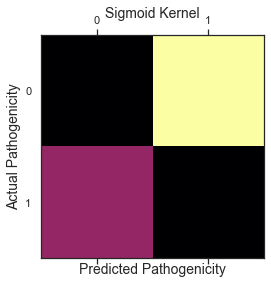

In [159]:
visualize_confusion(conf_mat, "Sigmoid Kernel")

In [90]:
def test_clfs(*clfs): # clf -> classifier
    for clf in clfs:
        # making an array to hold the scores
        accuracy_scores = np.zeros(100, dtype = float)
        
        # making new train-test splits from balanced DFs sampled original yes/no DFs
        for i in range(100):
            sampleDF = yesDF.sample(n=82)
            balancedDF = pd.concat([sampleDF, noDF])
            X_train, X_test, y_train, y_test = train_test_split(balancedDF.drop(['base', 'gene', 'pathogenic'], axis = 1),
                                                        balancedDF.loc[:, 'pathogenic'], test_size=0.25)
            clf.fit(X_train, y_train) # train the classifier
            y_pred = clf.predict(X_test)
        
            score="{:.2f}".format(accuracy_score(y_test, y_pred)) # add accuracy score to the scores array
            accuracy_scores[i] = score
 
        print(clf.__class__.__name__ + "  Mean Accuracy:","{:.2f}".format(accuracy_scores.mean()), 
        clf.__class__.__name__ + "  Std dev:", "{:.2f}".format(accuracy_scores.std(ddof=1)))

In [91]:
svm_sig_clf = SVC(random_state=0, probability=True, kernel='sigmoid')
svm_poly_clf = SVC(random_state=0, probability=True, kernel='poly')
svm_default = SVC(random_state=0, probability=True)

In [92]:
test_clfs(svm_sig_clf, svm_poly_clf, svm_default)

SVC  Mean Accuracy: 0.56 SVC  Std dev: 0.08
SVC  Mean Accuracy: 0.55 SVC  Std dev: 0.07
SVC  Mean Accuracy: 0.55 SVC  Std dev: 0.08


In [94]:
svm_sigpred = svm_sig_clf.predict(X_test)
svm_polypred = svm_poly_clf.predict(X_test)
svm_pred = svm_default.predict(X_test)

In [95]:
conf_mat = confusion_matrix(y_test, svm_pred)
print(conf_mat)

confusion = pd.DataFrame(conf_mat, index = ['no', 'yes'],
                         columns = ['no', 'yes'])

[[ 2 17]
 [ 0 22]]


In [96]:
conf_mat = confusion_matrix(y_test, svm_polypred)
print(conf_mat)

confusion = pd.DataFrame(conf_mat, index = ['no', 'yes'],
                         columns = ['no', 'yes'])

[[ 2 17]
 [ 0 22]]


In [97]:
conf_mat = confusion_matrix(y_test, svm_sigpred)
print(conf_mat)

confusion = pd.DataFrame(conf_mat, index = ['no', 'yes'],
                         columns = ['no', 'yes'])

[[ 3 16]
 [ 1 21]]
